<a href="https://colab.research.google.com/github/constantbourdrez/DL_ESPCI/blob/main/lab_recurrent_meteo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import torch  as th
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
from torchvision import transforms
import pandas as pd
import seaborn as sns
from tqdm import tqdm

# Introduction
The SYNOP meteorological data, can be found on [this site](https://public.opendatasoft.com) and if you want more details [go to this page](https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm/information/?sort=date). We will a prepared dataset which contains a set of measurements (temperature, pressure, ...) made every 3 hours at the ORLY airport.The objective will be to predict the evolution of the weather ! We will start by building a simple model. The idea is to learn the weather of the next day.

## Reminder

Recurrent networks in *pytorch* expects as input a Tensor in 3 dimensions (*3D tensor*). The axes carry an important semantic:
- the first axis is the mini-batch
- the second one corresponds to  "the time"
- the third corresponds to the dimension of input vectors (typically the embedding size or the number of input channels)


Therefore, a sequence of 5 vectors of 4 features (size 4) is represented as a Tensor of dimensions (1,5,4). If we have 7 sequences of 5 vectors, all of size 4, we get (7,5,4) (aside note: in some example,  the first two dimensions can be swapped).  

Lets start with some simple code with synthetic data. The goal is to "play" with the recurrent network, to understand the dimensions and how it works.


In [3]:
th.manual_seed(1) # To reproduce the experiments
inputs = th.randn((1,5,4))
print("input sequence :", inputs)
print("The shape : ", inputs.shape)

input sequence : tensor([[[-1.5256, -0.7502, -0.6540, -1.6095],
         [ 0.8657,  0.2444, -0.6629,  0.8073],
         [ 0.4391,  1.1712,  1.7674, -0.0954],
         [ 0.0612, -0.6177, -0.7981, -0.1316],
         [-0.7984,  0.3357,  0.2753,  1.7163]]])
The shape :  torch.Size([1, 5, 4])


# A simple recurrent model and  LSTM

A simple recurrent network is for instance of the thpe **nn.RNN**.
To build it, we must specify:
- the input size (this implies the size of the Linear Layer that will process input vectors);
- the size of the hidden layer (this implies the size of the Linear Layer that will process the time transition).

Other options are available and useful, like:
- nonlinearity
- bias
- batch_first


The forward function of a recurrent net can handle two types of input and therefore acts in two ways.

## One step forward
The first one corresponds to one time step: the neural networks reads one input symbol and update the hidden layer. The forward function therefore returns a tuple of two Tensors: the output and the updated hidden layer.



In [4]:
recNN = nn.RNN(input_size=4, hidden_size=3,batch_first=True)  # Input dim is 4, hidden layer size  is 3

# initialize the hidden state.
# The hidden units initialisation must adapt to data dimensions,
# including the mini-batch dimension.
h0 = th.randn(1, 1, 3)
print("h0 : ",h0,h0.shape)

# One step
out, hn = recNN(inputs[0,0,:].view(1,1,-1), h0)
# The view is just to ensure 3 dimensions. Try without !
print("##################")
print("One step returns: ")
print("  1/  output : ", out, out.shape)
print("  2/  hidden : ", hn, hn.shape)
print("##################")

h0 :  tensor([[[-0.8737, -0.2693, -0.5124]]]) torch.Size([1, 1, 3])
##################
One step returns: 
  1/  output :  tensor([[[-0.6307, -0.0205,  0.0848]]], grad_fn=<TransposeBackward1>) torch.Size([1, 1, 3])
  2/  hidden :  tensor([[[-0.6307, -0.0205,  0.0848]]], grad_fn=<StackBackward0>) torch.Size([1, 1, 3])
##################


We can observe that both vectors are the same. Indeed, in a simple recurrent network there is no distinction between the output and the hidden layers.  A prediction can be done by taking into account at each time step this hidden layer:

$$ h_t = f_1(x_t,h_{t-1})$$
$$ y_t = f_2(h_t)$$

For one step forward, the recurrent net only needs to keep track of the hidden layer. The more advanced cell called **LSTM** uses  two kinds of hidden layers: one for the memory managment  named **cell state** (or $c_t$), and the other to make the prediction named  **hidden state** (or $h_t$). The API is almost generic for all the recurrent nets and returns a tuple at each time step. This tuple gathers the sufficient data to unfold the network.

## Sequence forward (unfold)
The second "style" of the forward function consists in taking as input a sequence and to unfold the network on this input sequence. It is equivalent to a for loop.


In [5]:
# Process the whole sequence in one call: unfolding the network
outputs, hn = recNN(inputs, h0)
print("* outputs:\n",outputs, "\n  shape:",outputs.shape,"\n")
print("* hn:\n",hn, "\n  shape:",hn.shape)

* outputs:
 tensor([[[-0.6307, -0.0205,  0.0848],
         [-0.5812,  0.7743,  0.2956],
         [-0.2936,  0.9483,  0.1993],
         [-0.7406,  0.7238,  0.6722],
         [-0.9548,  0.5780,  0.7488]]], grad_fn=<TransposeBackward1>) 
  shape: torch.Size([1, 5, 3]) 

* hn:
 tensor([[[-0.9548,  0.5780,  0.7488]]], grad_fn=<StackBackward0>) 
  shape: torch.Size([1, 1, 3])


in this case, the forward function returns:
- the sequence of the hidden layers associated to each input vector;
- and the last hidden layer.
The previous code is to some extent equivalent to this one:

In [6]:
hn=h0 # init
for t in range(inputs.shape[1]):
    out, hn = recNN(inputs[0,t].view(1,1,-1), hn)
    print("at time ",t, " out = ", out)

at time  0  out =  tensor([[[-0.6307, -0.0205,  0.0848]]], grad_fn=<TransposeBackward1>)
at time  1  out =  tensor([[[-0.5812,  0.7743,  0.2956]]], grad_fn=<TransposeBackward1>)
at time  2  out =  tensor([[[-0.2936,  0.9483,  0.1993]]], grad_fn=<TransposeBackward1>)
at time  3  out =  tensor([[[-0.7406,  0.7238,  0.6722]]], grad_fn=<TransposeBackward1>)
at time  4  out =  tensor([[[-0.9548,  0.5780,  0.7488]]], grad_fn=<TransposeBackward1>)


In [7]:
device = th.device("cuda" if th.cuda.is_available() else "cpu")

## Usage of GRU and LSTM

**TODO:**Try to the same code as the previous cells with GRU first and then LSTM.  


In [8]:
## GRU
GRU = nn.GRU(input_size = 4, hidden_size = 3)
# The hidden units initialisation must adapt to data dimensions,
# including the mini-batch dimension.
h0 = th.randn(1, 1, 3)
print("h0 : ",h0,h0.shape)
hidden_states = []
for i in range(inputs.shape[1]):
  out, h0 = GRU(inputs[:,i,:], h0.view(1,3))
  hidden_states.append(h0)

print("hidden_states : ", hidden_states)

h0 :  tensor([[[-0.2997, -0.6933, -0.1668]]]) torch.Size([1, 1, 3])
hidden_states :  [tensor([[-0.0480, -0.7496, -0.3217]], grad_fn=<SqueezeBackward1>), tensor([[-0.1352, -0.4181,  0.2507]], grad_fn=<SqueezeBackward1>), tensor([[ 0.1731, -0.3384, -0.2532]], grad_fn=<SqueezeBackward1>), tensor([[ 0.0534, -0.4024,  0.0959]], grad_fn=<SqueezeBackward1>), tensor([[0.0485, 0.0789, 0.2117]], grad_fn=<SqueezeBackward1>)]


In [9]:
h0 = th.randn(1, 5, 3)

out, h0 = GRU(inputs.view(1,5,4), h0)
print("hidden_states : ", h0)

hidden_states :  tensor([[[-0.1129, -1.2474,  0.4522],
         [-0.1719,  0.7812,  0.5518],
         [ 0.6192, -1.1305, -0.5322],
         [-0.9264, -0.2498,  0.0075],
         [ 0.7143,  0.5179, -0.4513]]], grad_fn=<StackBackward0>)


In [10]:
## LSTM
LSTM = nn.LSTM(input_size = 4, hidden_size = 3)
# The hidden units initialiation must adapt to data dimensions,
# including the mini-batch dimension.
h0 = th.randn(1, 1, 3)
c0 = th.randn(1, 1, 3)
print("h0 : ",h0,h0.shape)
hidden_states = []
c_states= []
for i in range(inputs.shape[1]):
  out, (h0, c0) = LSTM(inputs[:,i], (h0.view(1,3), c0.view(1,3)))
  hidden_states.append(h0)
  c_states.append(c0)
print("hidden_states : ", hidden_states)
print("c_states : ", c_states)

h0 :  tensor([[[ 0.6016, -0.4929,  1.5050]]]) torch.Size([1, 1, 3])
hidden_states :  [tensor([[-0.3259, -0.0710, -0.0581]], grad_fn=<SqueezeBackward1>), tensor([[-0.4746,  0.0643, -0.1271]], grad_fn=<SqueezeBackward1>), tensor([[-0.0802, -0.3835, -0.1356]], grad_fn=<SqueezeBackward1>), tensor([[-0.2946, -0.1002, -0.0688]], grad_fn=<SqueezeBackward1>), tensor([[ 0.0863, -0.0375, -0.0536]], grad_fn=<SqueezeBackward1>)]
c_states :  [tensor([[-1.3089, -0.0883, -0.2269]], grad_fn=<SqueezeBackward1>), tensor([[-0.8018,  0.0975, -0.1943]], grad_fn=<SqueezeBackward1>), tensor([[-0.1942, -0.5907, -0.3344]], grad_fn=<SqueezeBackward1>), tensor([[-0.4578, -0.1663, -0.1340]], grad_fn=<SqueezeBackward1>), tensor([[ 0.1308, -0.1023, -0.1340]], grad_fn=<SqueezeBackward1>)]


In [11]:
h0 = th.randn(1, 5, 3)
c0 = th.randn(1,5,3)
out, (hn, cn) = LSTM(inputs.view(1,5,4), (h0, c0))
print("hidden_states : ", hn)
print("c_states : ", cn)

hidden_states :  tensor([[[-0.2262, -0.2406,  0.1405],
         [-0.3828, -0.0697,  0.4394],
         [ 0.0462, -0.1148, -0.3676],
         [-0.3177,  0.1912, -0.4365],
         [ 0.0453, -0.0942, -0.1149]]], grad_fn=<StackBackward0>)
c_states :  tensor([[[-0.4215, -0.6207,  0.7192],
         [-0.4975, -0.1532,  0.8093],
         [ 0.1358, -0.1458, -1.0729],
         [-0.7096,  0.2783, -1.0559],
         [ 0.0646, -0.2150, -0.3264]]], grad_fn=<StackBackward0>)


# Data set : weather forecast
The dataset comes from this [open data site](https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm/table/?sort=date&refine.nom=ORLY). After a filtering step and feature selection we end up with the following features (in French):  
- Pression au niveau mer
- Variation de pression en 3 heures
- Direction du vent moyen 10 mn
- Vitesse du vent moyen 10 mn
- Température
- Point de rosée
- Humidité


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
ls /content/drive/MyDrive/DL

ADL-GAN-Sheep.ipynb   conv-cifar10.pth           meteo-orly.csv      oninou.jpg
ADL_lab_ResNet.ipynb  imagenet_class_index.json  meteo-test.py.npy   pig.jpg
ADL_lab_TP1.ipynb     lab-recurrent-meteo.ipynb  meteo-train.py.npy  sheep.npy


In [14]:
folder_path = '/content/drive/MyDrive/DL/'
train = np.load(f"{folder_path}meteo-train.py.npy",allow_pickle=True)
test  = np.load(f"{folder_path}meteo-test.py.npy",allow_pickle=True)
train = train[:, 1:]
test = test[:, 1:]
shape = np.shape(train)
test = test.astype(np.float32)
train = train.astype(np.float32)
ptest = th.tensor(test, dtype=th.float32)
ptrain = th.tensor(train, dtype=th.float32)
mean_train = th.mean(ptrain, dim=0)  # Compute mean along rows
std_train = th.std(ptrain, dim=0)    # Compute standard deviation along rows


ptrain = (ptrain - mean_train)/std_train



ptest = (ptest - mean_train)/std_train

train = ptrain.numpy()


**TODO**:
- Explore the data, look at the values, their respective scales, ...  and create Tensors with the useful part (we can skip the date, for pytorch).
- Given the different scales involved, it is more efficient to normalize the data: compute the mean and variance for each component on the training set and whiten the datasets.  

In [15]:
tmp = pd.DataFrame(train, columns = ['P', 'delta P', 'Vent', 'Vitesse vent', 'T', 'Rosée', 'Humidité'])
tmp.describe()

,P,delta P,Vent,Vitesse vent,T,Rosée,Humidité
count,30520.000000,3.052000e+04,3.052000e+04,3.052000e+04,30520.000000,30520.000000,3.052000e+04
mean,-0.000007,1.440511e-08,-3.299738e-08,1.859852e-07,-0.000003,0.000002,6.799461e-08
std,1.000000,9.999999e-01,1.000000e+00,1.000000e+00,1.000000,1.000000,9.999999e-01
min,-5.070066,-7.990281e+00,-1.760877e+00,-1.741218e+00,-3.380685,-4.877411,-3.372767e+00
25%,-0.558888,-5.599332e-01,-9.949345e-01,-6.892395e-01,-0.714809,-0.690220,-7.115000e-01
50%,0.052797,-6.596935e-04,1.539790e-01,-1.882972e-01,-0.051790,0.049753,2.510862e-01
75%,0.642636,5.586138e-01,7.284357e-01,5.631163e-01,0.694103,0.753638,8.173133e-01
max,3.307836,9.906471e+00,1.685864e+00,6.223764e+00,4.050622,2.793086,1.440163e+00


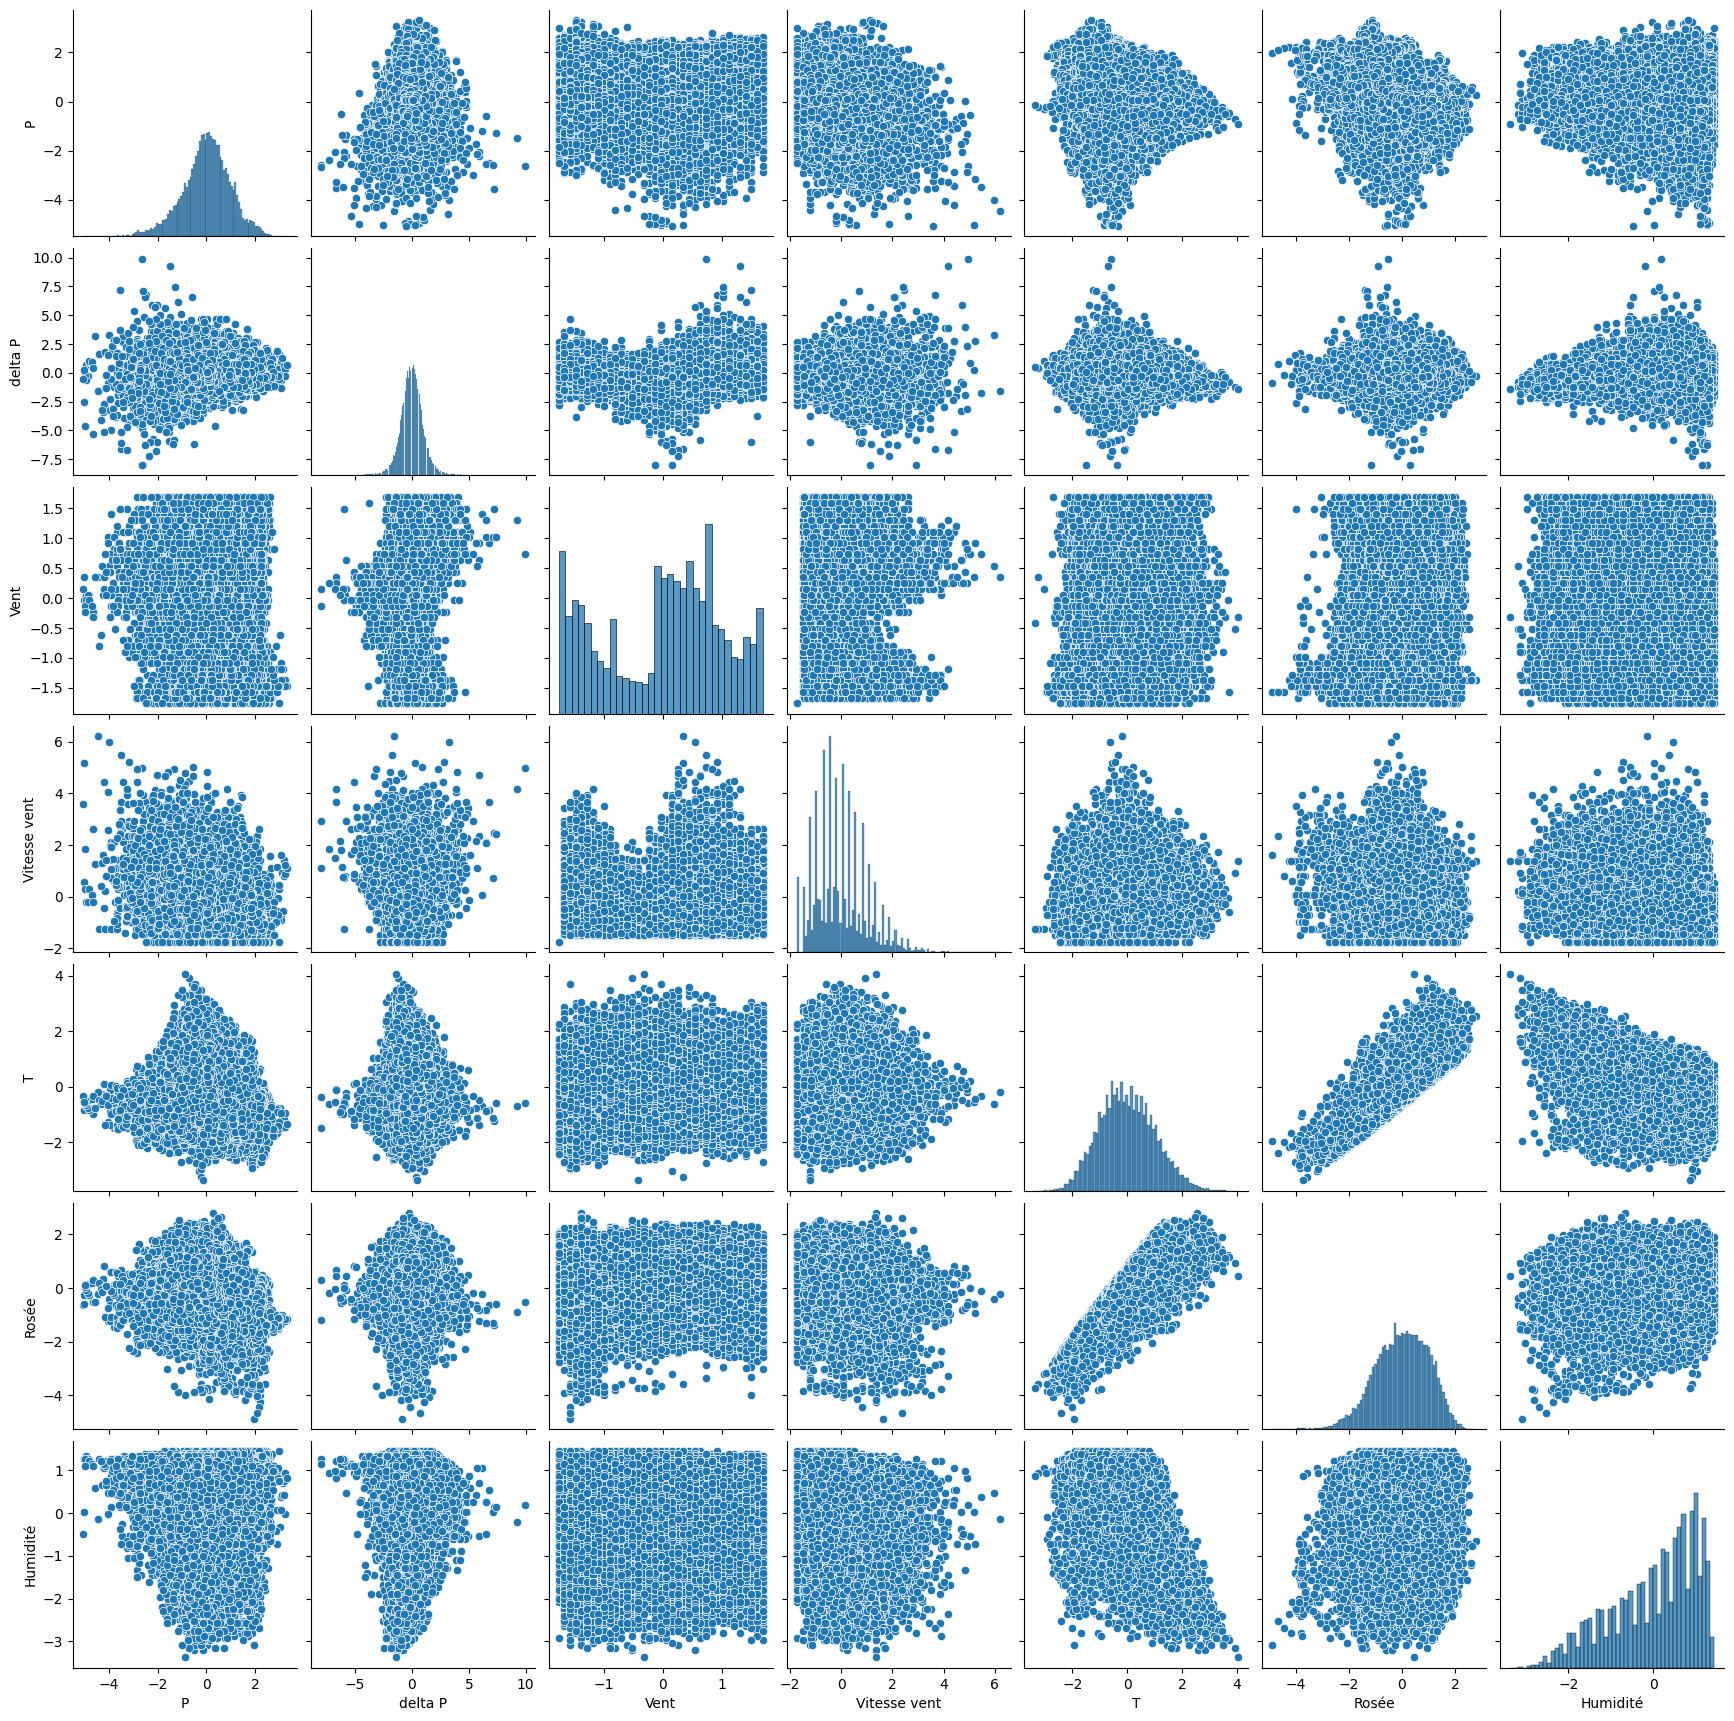

In [16]:
sns.pairplot(tmp)

## Reshaping the data

We want to train the recurrent network with mini-batches of size *bsz*. To make it simple we consider all the sequences in the mini-batch have the same size: *ls=16* time steps.

**TODO:**
- write a function that takes the traindata and transforms it in a Tensor of size (B,L=16,7);
- test it to be sure everything is correct (you can try to plot some subparts for instance).

In [62]:
def split_batch(tensor, batch_size):
  shape = tensor.shape
  number_of_batch = shape[0] // batch_size
  rest = shape[0] % batch_size
  print(f"{rest} items not taken")
  return tensor.contiguous()[:number_of_batch*batch_size, :].view(number_of_batch, batch_size, 7)

In [63]:
print(split_batch(ptrain, 16).shape, split_batch(ptest, 16).shape)

8 items not taken
15 items not taken
torch.Size([1907, 16, 7]) torch.Size([476, 16, 7])


In [93]:
 b = split_batch(ptrain, 16)

8 items not taken


8 items not taken


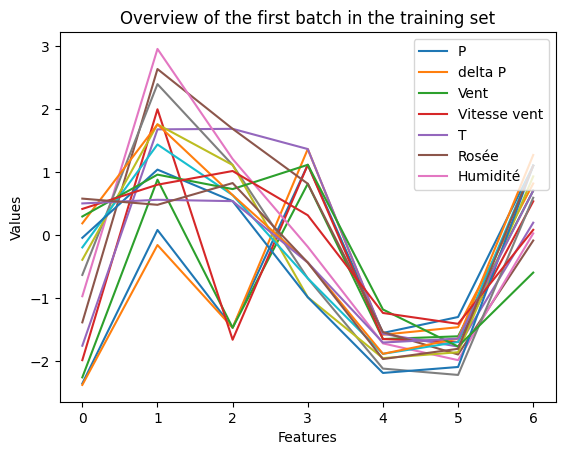

In [70]:
plt.plot(split_batch(ptrain, 16)[0].numpy().T)
plt.title('Overview of the first batch in the training set')
plt.xlabel('Features')
plt.ylabel('Values')
plt.legend(['P', 'delta P', 'Vent', 'Vitesse vent', 'T', 'Rosée', 'Humidité'])

In [140]:
from torch.utils.data import DataLoader
trainloader = DataLoader(split_batch(ptrain,16), batch_size = 100, shuffle = False)
testloader = DataLoader(split_batch(ptest,16), batch_size = 100, shuffle = False)

8 items not taken
15 items not taken


# Recurrent model
The idea is to train a recurrent model that can predict the weather of the next day given the past observation.
To learn the model we will sequences of length 16.

## Put pieces together
To set up everything we can first play with each component on  a toy batch.

The first network is composed as follows:
- A GRU cell
- A linear output layer to generate

**TODO**: fill the cell below with a GRU cell and a Linear layer. It should work !


## Build your own module

Writing your own module is easy in pytorch. It allows you to wrap what you have seen so far. To debug the model, you can first play step-by-step with each layer to ensure you are right with dimensions (it was done earlier). Then, write the class and run the training to evaluate the result (this what we have to do now).

The class inherits from an existing class of pytorch : Module. This means that your class is a Module, but we add some peculiarities. For that purpose you can fill the following code. The two most important parts are the constructor and the forward method.

In [105]:
class GRUPredictor(nn.Module):
    """GRUPredictor is a recurrent model. It takes as input a vector and predict
    the next one given past observations."""
    def __init__(self, input_dim=7, hidden_dim=50, nstack = 1, dropout=0):
        super(GRUPredictor, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.nstack = nstack
        self.dropout = dropout
        self.gru = nn.GRU(input_size=input_dim, hidden_size = hidden_dim,  num_layers = nstack)
        self.linear = nn.Linear(in_features = hidden_dim, out_features = input_dim)
        self.drop = nn.Dropout(p = dropout)
    def init_hidden(self, bsz):
        # This function is given: understand it.
        self.h = th.zeros(self.nstack, bsz, self.hidden_dim)

    def forward(self, inputs, h0=None):
        if h0 == None:
          h0 = self.init_hidden(inputs.shape[0])
        hidden, h0 = self.gru(inputs, h0)
        #out = self.dropout(hidden)
        out = self.linear(hidden)
        return out




In [143]:
# A simple test of the model on a mini-batch
model = GRUPredictor()
pred = model(b)
print(pred.shape)
lossfn = nn.MSELoss()
lossfn(pred[1:-1], b[2:])


torch.Size([1907, 16, 7])


tensor(1.0027, grad_fn=<MseLossBackward0>)

In [132]:
(pred[1:-1] -  b[2:] < 1e-2).sum().item()

110758

# A first forecasting model: training and evaluation

Now we have everything. It is time to build a model and to train it:
- select the loss function
- the optimizer can be Adam with a low initial learning (e.g 1e-3 or 5e-4)
- the training algorithm will process mini-batch of e.g 100 sequences (length 16 for each sequence)
- for the validation monitoring, you can use the test set or take the last 10% of sequences
- you can start with a hidden dimension of size 10 and try higher values.



In [136]:
def validation_score(model, dsetloader, gpu = True, epsilon = 1e-2):
    """Compute the classification accuracy and the loss function on the validation set """

    #define the criterion used to compute the validation score

    criterion = nn.MSELoss()


    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with th.no_grad():
        for inputs in dsetloader:
          if gpu:
            inputs= inputs.to(device)
          outputs = model(inputs)
          loss = criterion(outputs[1:-1], inputs[2:])


          running_loss += loss.item()


          correct_predictions += (abs(outputs[1:-1] - inputs[2:]) < epsilon).sum().item() / 7
          total_samples += inputs.size(0)

    average_loss = running_loss / len(dsetloader)
    accuracy = correct_predictions / total_samples

    return average_loss, accuracy


In [124]:
def train_model(model, trainsetloader, testsetloader, lr = 1e-3, nepochs = 10, gpu = False):
  optimizer = optim.Adam(model.parameters(), lr = lr)
  lossfn = nn.MSELoss()
  train_losses, valid_losses, accuracies = [], [], []
  for epoch in tqdm(range(nepochs)):
    running_loss = 0
    for inputs in trainsetloader:
      if gpu:
        inputs = inputs.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = lossfn(outputs[1:-1], inputs[2:])
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

    train_loss = running_loss / len(trainsetloader)

    average_loss, accuracy = validation_score(model, testsetloader, gpu = gpu)
    valid_losses.append(average_loss)
    accuracies.append(accuracy)
    train_losses.append(train_loss)

    print(f"Epoch {epoch + 1}/{nepochs} -> "
          f"Train Loss: {train_loss:.4f}, "
          f"Validation Loss: {average_loss:.4f}, "
          f"Validation Accuracy: {accuracy:.4f}")


  return model,train_losses, valid_losses, accuracies


  2%|▏         | 1/50 [00:00<00:23,  2.09it/s]

Epoch 1/50 -> Train Loss: 0.9134, Validation Loss: 0.8411, Validation Accuracy: 0.1444


  4%|▍         | 2/50 [00:00<00:23,  2.03it/s]

Epoch 2/50 -> Train Loss: 0.7670, Validation Loss: 0.7070, Validation Accuracy: 0.1531


  6%|▌         | 3/50 [00:01<00:23,  2.03it/s]

Epoch 3/50 -> Train Loss: 0.6935, Validation Loss: 0.6760, Validation Accuracy: 0.1723


  8%|▊         | 4/50 [00:01<00:22,  2.05it/s]

Epoch 4/50 -> Train Loss: 0.6716, Validation Loss: 0.6613, Validation Accuracy: 0.1771


 10%|█         | 5/50 [00:02<00:22,  2.04it/s]

Epoch 5/50 -> Train Loss: 0.6603, Validation Loss: 0.6518, Validation Accuracy: 0.1729


 12%|█▏        | 6/50 [00:03<00:23,  1.86it/s]

Epoch 6/50 -> Train Loss: 0.6526, Validation Loss: 0.6451, Validation Accuracy: 0.1921


 14%|█▍        | 7/50 [00:03<00:25,  1.67it/s]

Epoch 7/50 -> Train Loss: 0.6467, Validation Loss: 0.6394, Validation Accuracy: 0.1798


 16%|█▌        | 8/50 [00:04<00:26,  1.57it/s]

Epoch 8/50 -> Train Loss: 0.6418, Validation Loss: 0.6345, Validation Accuracy: 0.1873


 18%|█▊        | 9/50 [00:05<00:27,  1.50it/s]

Epoch 9/50 -> Train Loss: 0.6379, Validation Loss: 0.6305, Validation Accuracy: 0.1942


 20%|██        | 10/50 [00:06<00:27,  1.43it/s]

Epoch 10/50 -> Train Loss: 0.6346, Validation Loss: 0.6273, Validation Accuracy: 0.1849


 22%|██▏       | 11/50 [00:06<00:24,  1.56it/s]

Epoch 11/50 -> Train Loss: 0.6320, Validation Loss: 0.6248, Validation Accuracy: 0.1753


 24%|██▍       | 12/50 [00:07<00:22,  1.68it/s]

Epoch 12/50 -> Train Loss: 0.6299, Validation Loss: 0.6228, Validation Accuracy: 0.1876


 26%|██▌       | 13/50 [00:07<00:20,  1.78it/s]

Epoch 13/50 -> Train Loss: 0.6281, Validation Loss: 0.6211, Validation Accuracy: 0.1900


 28%|██▊       | 14/50 [00:08<00:19,  1.85it/s]

Epoch 14/50 -> Train Loss: 0.6264, Validation Loss: 0.6197, Validation Accuracy: 0.1858


 30%|███       | 15/50 [00:08<00:18,  1.91it/s]

Epoch 15/50 -> Train Loss: 0.6250, Validation Loss: 0.6184, Validation Accuracy: 0.1873


 32%|███▏      | 16/50 [00:08<00:17,  1.96it/s]

Epoch 16/50 -> Train Loss: 0.6236, Validation Loss: 0.6172, Validation Accuracy: 0.1885


 34%|███▍      | 17/50 [00:09<00:17,  1.92it/s]

Epoch 17/50 -> Train Loss: 0.6224, Validation Loss: 0.6162, Validation Accuracy: 0.1900


 36%|███▌      | 18/50 [00:10<00:16,  1.94it/s]

Epoch 18/50 -> Train Loss: 0.6213, Validation Loss: 0.6153, Validation Accuracy: 0.1909


 38%|███▊      | 19/50 [00:10<00:15,  1.98it/s]

Epoch 19/50 -> Train Loss: 0.6202, Validation Loss: 0.6144, Validation Accuracy: 0.1870


 40%|████      | 20/50 [00:10<00:14,  2.02it/s]

Epoch 20/50 -> Train Loss: 0.6192, Validation Loss: 0.6136, Validation Accuracy: 0.1792


 42%|████▏     | 21/50 [00:11<00:14,  2.00it/s]

Epoch 21/50 -> Train Loss: 0.6183, Validation Loss: 0.6129, Validation Accuracy: 0.1798


 44%|████▍     | 22/50 [00:11<00:13,  2.00it/s]

Epoch 22/50 -> Train Loss: 0.6174, Validation Loss: 0.6123, Validation Accuracy: 0.1915


 46%|████▌     | 23/50 [00:12<00:13,  2.01it/s]

Epoch 23/50 -> Train Loss: 0.6166, Validation Loss: 0.6117, Validation Accuracy: 0.1903


 48%|████▊     | 24/50 [00:12<00:12,  2.03it/s]

Epoch 24/50 -> Train Loss: 0.6158, Validation Loss: 0.6112, Validation Accuracy: 0.1951


 50%|█████     | 25/50 [00:13<00:12,  2.04it/s]

Epoch 25/50 -> Train Loss: 0.6151, Validation Loss: 0.6107, Validation Accuracy: 0.1903


 52%|█████▏    | 26/50 [00:13<00:11,  2.03it/s]

Epoch 26/50 -> Train Loss: 0.6144, Validation Loss: 0.6103, Validation Accuracy: 0.1906


 54%|█████▍    | 27/50 [00:14<00:11,  2.06it/s]

Epoch 27/50 -> Train Loss: 0.6137, Validation Loss: 0.6098, Validation Accuracy: 0.1930


 56%|█████▌    | 28/50 [00:14<00:10,  2.07it/s]

Epoch 28/50 -> Train Loss: 0.6131, Validation Loss: 0.6095, Validation Accuracy: 0.1888


 58%|█████▊    | 29/50 [00:15<00:10,  2.10it/s]

Epoch 29/50 -> Train Loss: 0.6125, Validation Loss: 0.6091, Validation Accuracy: 0.1975


 60%|██████    | 30/50 [00:15<00:09,  2.09it/s]

Epoch 30/50 -> Train Loss: 0.6119, Validation Loss: 0.6088, Validation Accuracy: 0.1972


 62%|██████▏   | 31/50 [00:16<00:09,  1.93it/s]

Epoch 31/50 -> Train Loss: 0.6113, Validation Loss: 0.6085, Validation Accuracy: 0.1999


 64%|██████▍   | 32/50 [00:17<00:10,  1.74it/s]

Epoch 32/50 -> Train Loss: 0.6107, Validation Loss: 0.6082, Validation Accuracy: 0.2020


 66%|██████▌   | 33/50 [00:17<00:10,  1.63it/s]

Epoch 33/50 -> Train Loss: 0.6102, Validation Loss: 0.6079, Validation Accuracy: 0.2017


 68%|██████▊   | 34/50 [00:18<00:10,  1.53it/s]

Epoch 34/50 -> Train Loss: 0.6097, Validation Loss: 0.6076, Validation Accuracy: 0.2053


 70%|███████   | 35/50 [00:19<00:10,  1.46it/s]

Epoch 35/50 -> Train Loss: 0.6091, Validation Loss: 0.6074, Validation Accuracy: 0.2011


 72%|███████▏  | 36/50 [00:19<00:08,  1.60it/s]

Epoch 36/50 -> Train Loss: 0.6086, Validation Loss: 0.6072, Validation Accuracy: 0.2056


 74%|███████▍  | 37/50 [00:20<00:07,  1.72it/s]

Epoch 37/50 -> Train Loss: 0.6081, Validation Loss: 0.6069, Validation Accuracy: 0.2104


 76%|███████▌  | 38/50 [00:20<00:06,  1.79it/s]

Epoch 38/50 -> Train Loss: 0.6076, Validation Loss: 0.6067, Validation Accuracy: 0.2101


 78%|███████▊  | 39/50 [00:21<00:05,  1.87it/s]

Epoch 39/50 -> Train Loss: 0.6071, Validation Loss: 0.6065, Validation Accuracy: 0.2098


 80%|████████  | 40/50 [00:21<00:05,  1.94it/s]

Epoch 40/50 -> Train Loss: 0.6067, Validation Loss: 0.6063, Validation Accuracy: 0.2170


 82%|████████▏ | 41/50 [00:22<00:04,  1.99it/s]

Epoch 41/50 -> Train Loss: 0.6062, Validation Loss: 0.6061, Validation Accuracy: 0.2155


 84%|████████▍ | 42/50 [00:22<00:03,  2.02it/s]

Epoch 42/50 -> Train Loss: 0.6057, Validation Loss: 0.6059, Validation Accuracy: 0.2173


 86%|████████▌ | 43/50 [00:23<00:03,  2.05it/s]

Epoch 43/50 -> Train Loss: 0.6052, Validation Loss: 0.6057, Validation Accuracy: 0.2140


 88%|████████▊ | 44/50 [00:23<00:02,  2.05it/s]

Epoch 44/50 -> Train Loss: 0.6048, Validation Loss: 0.6055, Validation Accuracy: 0.2113


 90%|█████████ | 45/50 [00:24<00:02,  2.03it/s]

Epoch 45/50 -> Train Loss: 0.6043, Validation Loss: 0.6054, Validation Accuracy: 0.2059


 92%|█████████▏| 46/50 [00:24<00:01,  2.04it/s]

Epoch 46/50 -> Train Loss: 0.6038, Validation Loss: 0.6052, Validation Accuracy: 0.2032


 94%|█████████▍| 47/50 [00:25<00:01,  2.05it/s]

Epoch 47/50 -> Train Loss: 0.6034, Validation Loss: 0.6050, Validation Accuracy: 0.2071


 96%|█████████▌| 48/50 [00:25<00:00,  2.08it/s]

Epoch 48/50 -> Train Loss: 0.6029, Validation Loss: 0.6049, Validation Accuracy: 0.2062


 98%|█████████▊| 49/50 [00:26<00:00,  2.07it/s]

Epoch 49/50 -> Train Loss: 0.6024, Validation Loss: 0.6047, Validation Accuracy: 0.2065


100%|██████████| 50/50 [00:26<00:00,  1.88it/s]

Epoch 50/50 -> Train Loss: 0.6020, Validation Loss: 0.6046, Validation Accuracy: 0.2059


Text(0, 0.5, 'MSELoss')

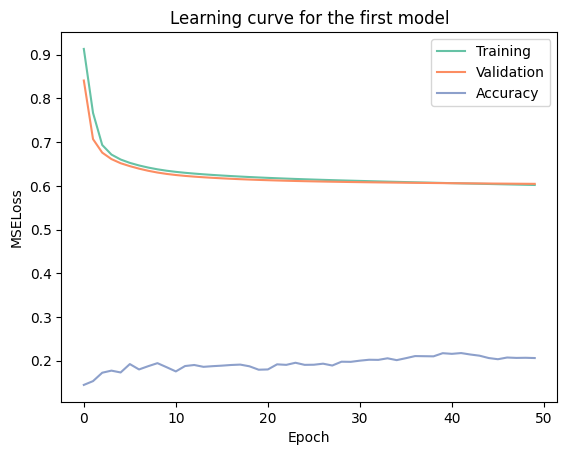

In [144]:
model, train_losses, valid_losses, accuracies = train_model(model, trainloader, testloader, nepochs = 50)

#Plot the results
sns.set_palette("Set2")
plt.plot(train_losses, label = 'Training')
plt.plot(valid_losses, label = 'Validation')
plt.plot(accuracies, label = 'Accuracy')
plt.legend()
plt.title('Learning curve for the first model')
plt.xlabel('Epoch')
plt.ylabel('MSELoss')

## Forecasting evaluation
Now you have a trained model, you can use it for forecasting. The first evaluation relies on the same conditions as the training: predict the 7 values for the day after given the true values observed for the current day.

**TODO:**
- compute the loss on the test set
- plot the prediction for 100 consecutive days


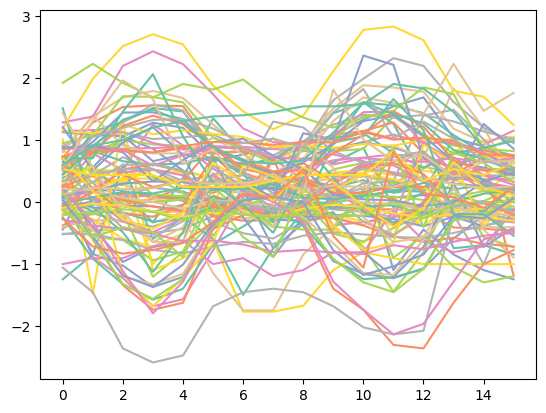

In [150]:
batch = next(iter(testloader))
preds = model(batch)
for i in range(7):
  plt.plot(preds[i,:].detach().numpy(), label = 'pred')
  plt.plot(batch[i,:].numpy(), label = 'exp')


## Long term forecasting

We can also evaluate long term predictions: let the model "reads" N=15 true values, and then generate the N following values. For this last generation step the model uses its own predictions as new input.

**TODO:**
- add a method in the class of your model that can "read" an input sequence and then generate N samples
- test it with N=15 samples taken from the test data
- plot the predictions, the truth along with the "one day" predictions for visual comparison
- to have a better evaluation, we can rescale the values.

# Stronger models
**TODO:**
- try to increase the size of the hidden layer, H=20,50,100.
- make the full evaluation as before
- you can also stack recurrent network. Modify the class to allow stacking recurrent layers


# Improved training
When you try to predict beyond the next day, the performance clearly drop.


**TODO:** propose and implement another training method.